In [1]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v=246.222
mh=125.13
#v=246
#mh=125
v2 = v**2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0,gs=1,mf=100):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        #self.gs=gs
        #self.mf=mf
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2
        
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot
    
    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end
 

        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys
     
    def oldboson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

    
        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4 + self.gs**2/6)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])
        
        return M, dof, c, Mphys

    
    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2        
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof, Mphys
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        #return [np.array([v,self.u]), np.array([-v,-self.u]),np.array([v,-self.u]),np.array([-v,self.u])]
        #return [np.array([v,self.u])]
        #return []
        X_1=m.findMinimum([0,-100],0)
        return [np.array([v,self.u]),X_1]
    
    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and self.lammix<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False
            
        
    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("mu3=",self.mu3, "muhs=",self.muhs,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")
        
        
    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0"""
        n=20
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True")
            return True
        for i in range(n):
            x1=np.random.uniform(0,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=m.Vtot(X_EW,0):
                break
        print("Global minimum found at X=",X0,"\n")
        delta_r=np.sum((X0-X_EW)**2)<1
        print("isEWSB=",delta_r,"\n")
        return delta_r 


    

####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
    


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum 
 ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity


 
def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restores at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"
    
    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR
    
    
def my_getPhases(m):
    myexps=[(-5,-3),(-5,-5),(-5,-4),(-3,-3)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out



def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes.
                It will be used by the other methods to find the nucleation and percolation parameters
    """
    if m.phases is None:
        try:
            #phases_dict=m.getPhases()
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-3, "tjump":1e-3})
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-4})
            phases_dict=my_getPhases(m)
        except:
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    for elem in crit_temps:
        if elem["trantype"]==1 and abs(elem["low_vev"][0]-elem["high_vev"][0])>10 and abs(elem["low_vev"][1]-elem["high_vev"][1])>10:
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
        else:
            continue
    if Num_relevant_trans==0:
        dict_output={}
        return dict_output
    else:
        dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
    X0=m.phases[dict_output["high_phase"]].X[0]
    T0=m.phases[dict_output["high_phase"]].T[0]
    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #print("DOING WHILE LOOP \n")
    #while stable:
    #    if T0<=0:
    #        break
    #    T0-=1e-4
    #    X0=m.findMinimum(X0,T0)
    #    if abs(X0[0])>0.1:
    #        break
    #    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #    print(" ................. \n")
    #    if stable==False:
    #        break
    def findminT(T):
        """Function to find the minimum temperature at which the high_vev coexists.
        Written in form for optimization"""
        Xmin=m.findMinimum(X0,T)
        dx=np.sum((Xmin-X0)**2)**0.5
        stable=not np.any(np.linalg.eig(m.d2V(Xmin,T))[0]<=0)
        if stable and (dx<.1) == False or T<0:
            return 500
        else:
            return stable and (dx<.1) + T
    Tmin_opt=optimize.fminbound(findminT,0,T0)
    dict_output["Tmin"]=Tmin_opt
    return dict_output




In [12]:
df=pd.read_csv("newNStab_vT15.csv",delimiter="\t").sort_values("αGW")
#df=df.iloc[:-14]
modi=-15

m=model1(ms = df.iloc[modi]["mH"], theta =-df.iloc[modi]["α"], muhs= df.iloc[modi]["μϕS"] ,  u = df.iloc[modi]["s0"], mu3 = df.iloc[modi]["μ3"])
thbool=m.theory_consistent()
m.print_couplings()


Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
Pis=m.lammix/6 + m.lams/4
lamh_tilde=m.lamh - m.lammix**2/4/m.lams
try: 
    del dict_out 
except: 
    None
dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"muhs":m.muhs,"mu3":m.mu3,
          "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
          "muh2":m.muh2,"mus2":m.mus2,
          "Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
if thbool==True:
    dict_out.update({ "th_bool":thbool})
    try:
        alltrans=m.findAllTransitions()
        index=0
        count_trans=0
        alpha_list=[]
        dT_list=[]
        trans_types=[]
        for elem in alltrans:
            if elem["trantype"]==1:
                count_trans+=1
                phi_stable=elem["low_vev"]
                phi_meta=elem["high_vev"]
                SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
                dh,ds=abs(phi_meta-phi_stable)
                trans_types.append(trans_class(SymNR))
                Tnuc=elem["Tnuc"]
                #Tc=elem["Tcrit"]
                dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
                dT_list.append(dT)
                Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
                alpha=alpha_GW(Tnuc,Delta_rho)
                alpha_list.append(alpha)
                dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
                                 "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
                                 "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,"alpha_"+str(index):alpha})
                index+=1
        relevant_index=alpha_list.index(max(alpha_list))
        dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
                         "dT_max":dT_list[relevant_index],
                         "tran_type":trans_types[relevant_index]})

    except:
        print("error")
        
        

Model is theoretically consistent 

Potential parameters are given by 
 
mus2= -26687.6192561349 muh2= 365.85387490470566 lamh= 0.12909262437465024 lams= 0.8713995109446692 lammix= 0.6876058928660022 

mu3= -309.935 muhs= 101.29103421172331 

Model parameters are 

ms= 114.20891350160612 theta= -0.043599900000000004 muhs= 101.29103421172331 u= -147.982 mu3= -309.935 

Tracing phase starting at x = [ 246.22199839 -147.98199646] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...................................................................................................................
Tracing phase starting at x = [ 3.56469747e-07 -7.38789002e+00] ; t = 129.51686126346414
Tracing minimum down
traceMinimum t0 = 129.517
...................................
Tracing minimum up
traceMinimum t0 = 129.517
..............................................
Tracing phase starting at x = [-3.05598781e-06 -5.25917808e+01] ; t = 257.1333288148669
Tracing minimum down
traceMinimum t0 = 257.133
.....

In [13]:
dict_out

{'ms': 114.20891350160612,
 'theta': -0.043599900000000004,
 'u': -147.982,
 'muhs': 101.29103421172331,
 'mu3': -309.935,
 'lamh': 0.12909262437465024,
 'lams': 0.8713995109446692,
 'lammix': 0.6876058928660022,
 'muh2': 365.85387490470566,
 'mus2': -26687.6192561349,
 'Pih': 0.42769803963548536,
 'Pis': 0.332450859880501,
 'lamh_tilde': -0.00655177809681079,
 'th_bool': True,
 'h_low_0': 230.07402271607356,
 's_low_0': -146.78955953926248,
 'h_high_0': -9.572763566733685e-06,
 's_high_0': -2.324346797743631,
 'Tnuc_0': 84.6767187373591,
 'dT_0': 57.09031013720083,
 'alpha_0': 0.030427593473145765,
 'num_FOPT': 1,
 'alpha_max': 0.030427593473145765,
 'dT_max': 57.09031013720083,
 'tran_type': 'hs-SNR'}

In [14]:
df.iloc[modi]

mH           114.208914
α              0.043600
s0          -147.982000
μ3          -309.935000
lS             0.871484
μϕ2          365.856931
μS2       -26685.773919
lϕ             0.129116
lϕS            0.687606
μϕS          101.291034
gψ             0.833111
mψ           323.109703
Tn            32.658970
Tp            29.894451
vT             9.414479
Tcrit        101.395558
vcTcrit        2.078358
αGW            2.445703
βH           107.990316
αGWHT          2.105115
βHHT         124.940298
αGWLT          2.119330
βHLT          11.813617
Name: 811, dtype: float64

In [15]:
m.phases

{0: Phase(key=0, X=[[246.2 -148], ..., [166.1 -123.1]], T=[0, ..., 128.5], dXdT=[[-0 -0], ..., [-44.53 83.17]],
 1: Phase(key=1, X=[[-0.0008594 -1.525], ..., [-5.6e-05 -51.84]], T=[71.43, ..., 256.1], dXdT=[[0.001142 -0.0495], ..., [-5.171e-05 -0.5776]],
 2: Phase(key=2, X=[[-0.0001144 -52], ..., [-0.0001346 -120.3]], T=[256.1, ..., 1000], dXdT=[[0.0001202 -0.5735], ..., [-0.000227 -0.0009153]]}

(v,u) is the global minima: True


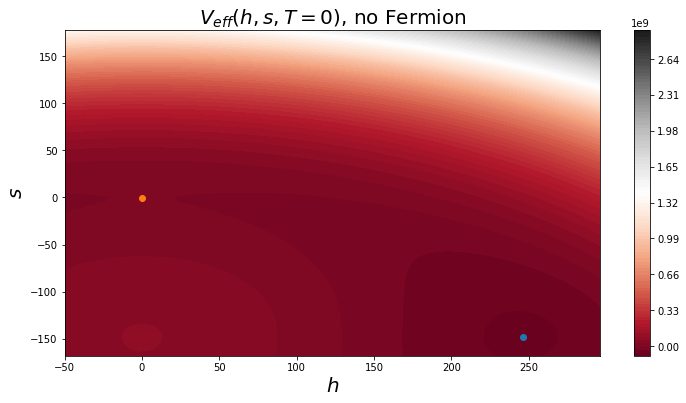

In [16]:
X_1=m.findMinimum([0,-100],0)
print("(v,u) is the global minima:",m.Vtot(X_1,0)>m.Vtot([v,m.u],0))


clevs=50
myN = 100
Temp=df.iloc[modi]["Tcrit"]*0
#Temp=dict_out["Tnuc_0"]
box=(-50,v+50,-m.u-np.sign(m.u)*30,m.u+np.sign(m.u)*20)
#box=(-50,v+50,-140,100)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + "), no Fermion",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)
ax1.scatter(v,m.u)
ax1.scatter(X_1[0],X_1[1])
plt.show()